## K-means clustering - segmenting retail data


### Data Set Information:
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">**Data Source**</a><br>This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


### Attribute Information:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.<br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br>
**Description**: Product (item) name. Nominal.<br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.<br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.<br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br>
**Country**: Country name. Nominal, the name of the country where each customer resides.

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np,pandas as pd,matplotlib.pyplot as plt,seaborn as sns,datetime as dt
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 1) Read and understand data

In [4]:
retail = pd.read_csv('Online_Retail.csv',encoding='ISO-8859-1')
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [5]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
retail.shape

(541909, 8)

## 2) Clean the data

In [7]:
retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# lets check the percentage of missing values

round((retail.isna().sum() / len(retail))*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

- here we can either drop the rows if percent is too small, drop the column if the percent is too large,impute values if needed
- In this case we can drop the null rows in description, and even though the percent is large enough in customerID we cannot drop the column since it is an important column for segmentation , so lets just drop the rows instead

In [9]:
retail.dropna(inplace=True)
retail.shape

(406829, 8)

In [10]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [11]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## 3) Prepare the data for modelling

**Points to keep in mind in customer segmentation**
- **R**: Recency (days from last perchase)
- **F**: Frequency (no of transactions)
- **M**: Monetary value(contribution to revenue)

**Note**-- Clustering can only be done on numerical attributes<br>
<br>
once RFM metrics are ready then(preprocessing):
- 1)Outlier treatment
- 2)rescaling

In [12]:
# creating new column Amount

retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [13]:
#Monetary
grp_cus = retail.groupby('CustomerID')['Amount'].sum()
grp_cus = grp_cus.reset_index()
grp_cus

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [14]:
#frequency

freq = retail.groupby('CustomerID')['InvoiceNo'].count()
freq = freq.reset_index()
freq.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
freq.columns = ['CustomerID','frequency']
freq

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [16]:
# merge the 2 DF by CustomerID

grp_cus = pd.merge(grp_cus,freq,on='CustomerID')
grp_cus

,CustomerID,Amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17
...,...,...,...
4367,18280.0,180.60,10
4368,18281.0,80.82,7
4369,18282.0,176.60,13
4370,18283.0,2094.88,756


In [17]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [18]:
# recency
# convert to datetime
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [19]:
#lets compute latest transaction date or maxdate
maxdate = max(retail['InvoiceDate'])
maxdate

Timestamp('2011-12-09 12:50:00')

In [20]:
retail['date_diff'] = maxdate - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,date_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [21]:
recency = retail.groupby('CustomerID')['date_diff'].min()
recency = recency.reset_index()
recency.columns = ['CustomerID','recency']
recency.head()

,CustomerID,recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [22]:
# merge the DF by CustomerID

grp_cus = pd.merge(grp_cus,recency,on='CustomerID')
grp_cus

,CustomerID,Amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00
...,...,...,...,...
4367,18280.0,180.60,10,277 days 02:58:00
4368,18281.0,80.82,7,180 days 01:57:00
4369,18282.0,176.60,13,7 days 01:07:00
4370,18283.0,2094.88,756,3 days 00:48:00


In [23]:
grp_cus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  4372 non-null   float64        
 1   Amount      4372 non-null   float64        
 2   frequency   4372 non-null   int64          
 3   recency     4372 non-null   timedelta64[ns]
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 170.8 KB


In [24]:
# we just need the days value in recency column
grp_cus['recency'] = grp_cus['recency'].dt.days
grp_cus.head()

,CustomerID,Amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [25]:
#outlier treatment
grp_cus.describe(percentiles=[0.05,0.25,0.5,0.75,0.9,0.95])

,CustomerID,Amount,frequency,recency
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1898.459701,93.053294,91.047118
std,1722.390705,8219.345141,232.471608,100.765435
min,12346.000000,-4287.630000,1.000000,0.000000
5%,12613.550000,101.138500,4.000000,2.000000
25%,13812.750000,293.362500,17.000000,16.000000
50%,15300.500000,648.075000,42.000000,49.000000
75%,16778.250000,1611.725000,102.000000,142.000000
90%,17685.900000,3505.600000,212.000000,263.000000
95%,17984.450000,5625.004000,317.900000,312.000000


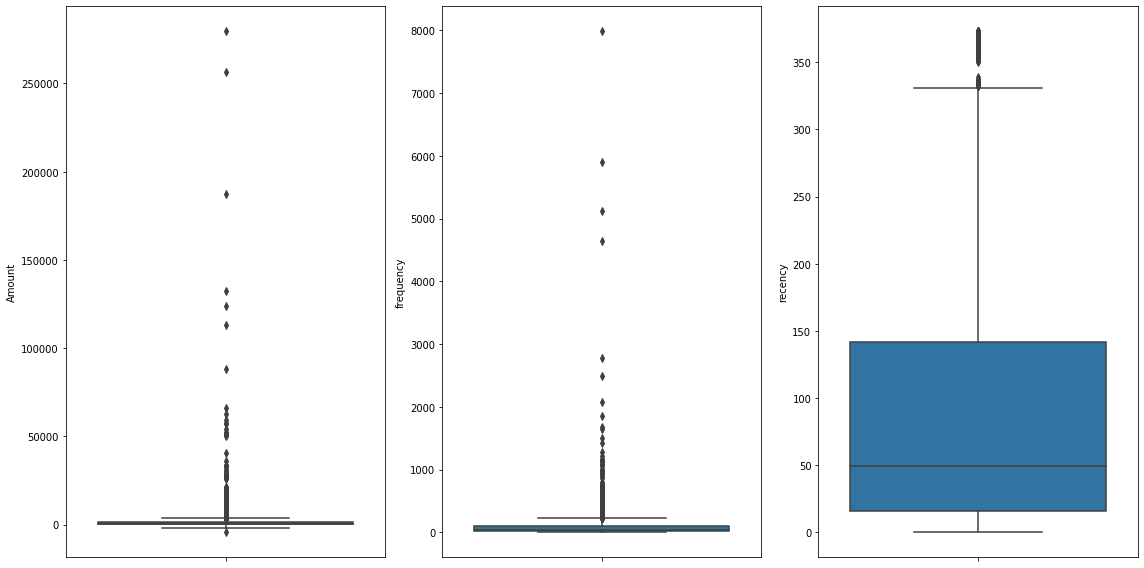

In [26]:
fig,axes = plt.subplots(1,3,figsize=(16,8))
sns.boxplot(y= grp_cus['Amount'],ax=axes[0])
sns.boxplot(y= grp_cus['frequency'],ax=axes[1])
sns.boxplot(y= grp_cus['recency'],ax=axes[2])
plt.tight_layout()

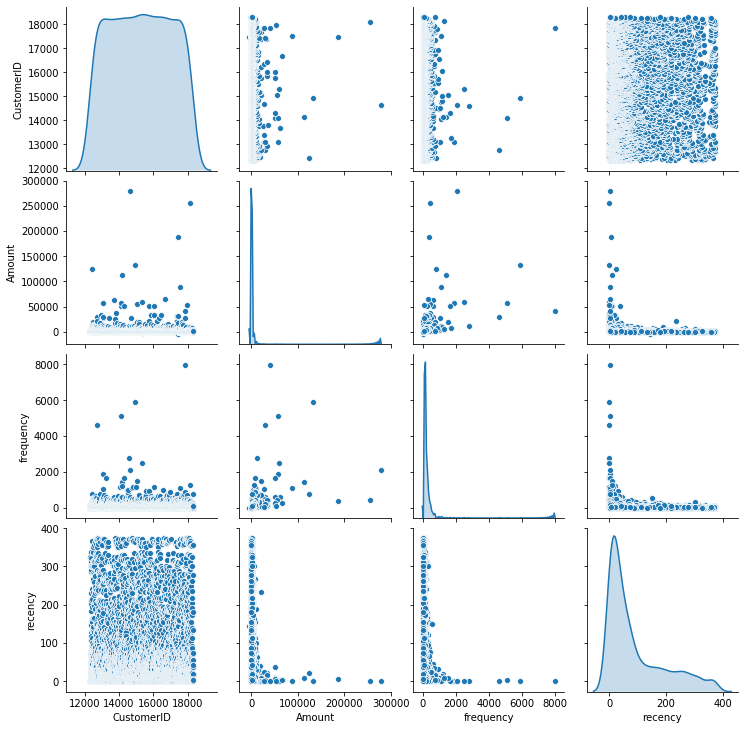

In [27]:
sns.pairplot(grp_cus,diag_kind='kde')

In [28]:
# two types of outliers:
# - statistical
# - domain specific

In [29]:
# removing (statistical) outliers
Q1 = grp_cus['Amount'].quantile(0.05)
Q3 = grp_cus['Amount'].quantile(0.95)
IQR = Q3 - Q1
grp_cus = grp_cus[(grp_cus['Amount'] >= Q1 - 1.5*IQR) & (grp_cus['Amount'] <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grp_cus['recency'].quantile(0.05)
Q3 = grp_cus['recency'].quantile(0.95)
IQR = Q3 - Q1
grp_cus = grp_cus[(grp_cus['recency'] >= Q1 - 1.5*IQR) & (grp_cus['recency'] <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grp_cus['frequency'].quantile(0.05)
Q3 = grp_cus['frequency'].quantile(0.95)
IQR = Q3 - Q1
grp_cus = grp_cus[(grp_cus['frequency'] >= Q1 - 1.5*IQR) & (grp_cus['frequency'] <= Q3 + 1.5*IQR)]


In [30]:
grp_cus.describe()

,CustomerID,Amount,frequency,recency
count,4293.000000,4293.000000,4293.000000,4293.000000
mean,15299.900769,1270.411464,77.483578,92.548567
std,1722.942628,1755.551155,100.270448,101.006845
min,12346.000000,-4287.630000,1.000000,0.000000
25%,13811.000000,289.360000,17.000000,17.000000
50%,15304.000000,632.970000,40.000000,50.000000
75%,16779.000000,1518.430000,97.000000,145.000000
max,18287.000000,13677.590000,718.000000,373.000000


In [31]:
#rescaling

In [32]:
rfm_df = grp_cus[['Amount','frequency','recency']]
rfm_df.head()

,Amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [33]:
scaler = StandardScaler()

In [34]:
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled , columns=['Amount','frequency','recency'])
rfm_df_scaled.head()

,Amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## 4) Modelling

In [35]:
# k-means with an arbitrary value of K
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([0, 3, 1, ..., 0, 1, 1])

### Elbow curve-- to find the optimal no of K

In [36]:
range_n_cluster = list(range(2,9))
range_n_cluster

[2, 3, 4, 5, 6, 7, 8]

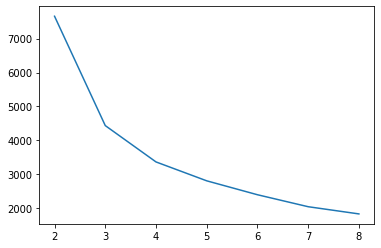

In [37]:
ssd= []
for num_cluster in range_n_cluster:
    kmeans = KMeans(n_clusters=num_cluster,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)
    
plt.plot(range_n_cluster,ssd);

From above elbow curve we can conclude that our elbow is at 3,hence we can choose $K=3$

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

for 2 clusters the silhouette_score = 0.5415858652525395
for 3 clusters the silhouette_score = 0.5084896296141937
for 4 clusters the silhouette_score = 0.48185520134959714
for 5 clusters the silhouette_score = 0.4662700564189704
for 6 clusters the silhouette_score = 0.41771162187117405
for 7 clusters the silhouette_score = 0.41768907282021733
for 8 clusters the silhouette_score = 0.40912829227908964


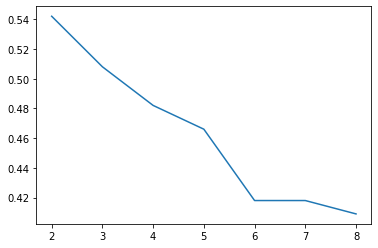

In [38]:
# Silhouette analysis
silhouette = []
for n_cluster in range_n_cluster:
    # initialize Kmeans
    kmeans = KMeans(n_clusters=n_cluster,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    #cluster labels
    cluster_labels = kmeans.labels_
    #silhouette score
    s_score = silhouette_score(rfm_df_scaled,cluster_labels)
    silhouette.append(round(s_score,3))
    
    print('for {} clusters the silhouette_score = {}'.format(n_cluster,s_score))

plt.plot(range_n_cluster,silhouette);

> With above analysis lets move ahead with k=3 for final model

In [39]:
# final k-means model with an  value of K = 3

kmeans_3 = KMeans(n_clusters=3,max_iter=50)
kmeans_3.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [40]:
kmeans_3.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [41]:
grp_cus['cluster_id'] = kmeans_3.labels_

In [42]:
grp_cus

,CustomerID,Amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1
...,...,...,...,...,...
4366,18278.0,173.90,9,73,0
4367,18280.0,180.60,10,277,1
4368,18281.0,80.82,7,180,1
4369,18282.0,176.60,13,7,0


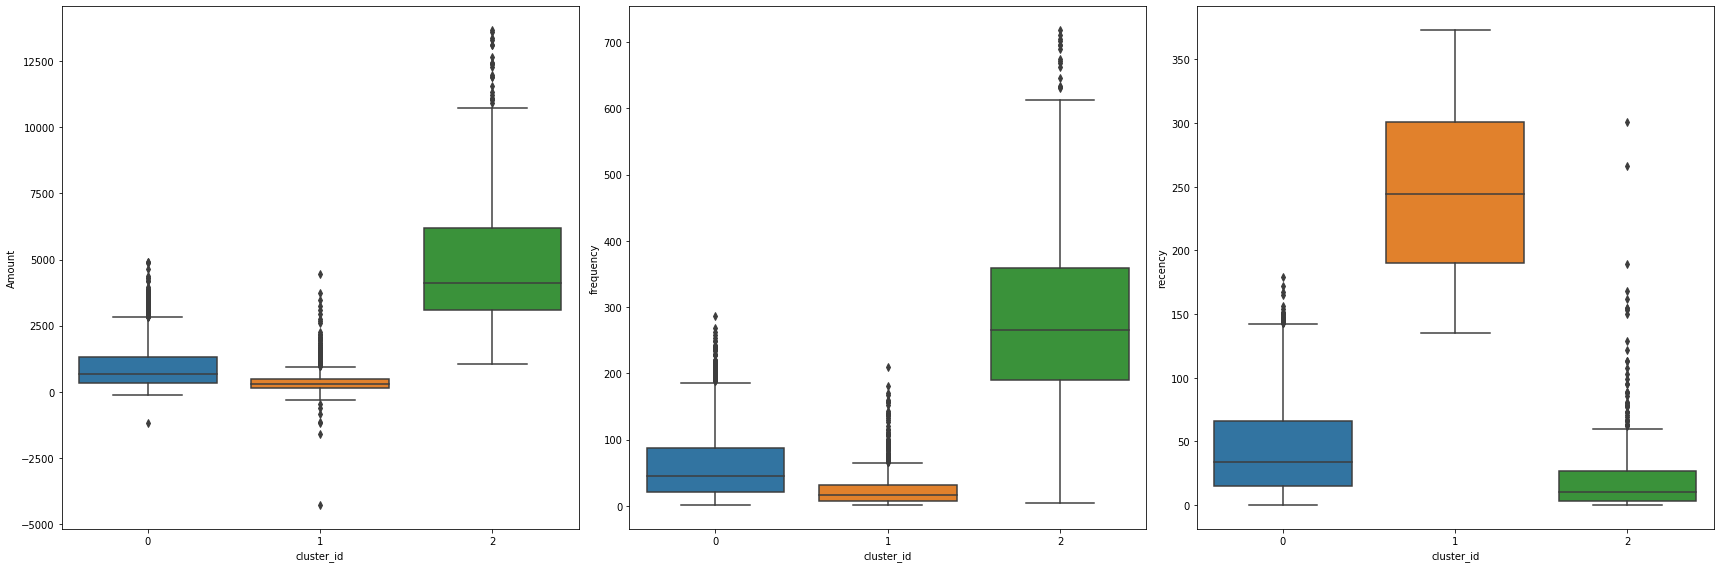

In [43]:
fig,axes = plt.subplots(1,3,figsize=(24,8))
sns.boxplot(x='cluster_id',y='Amount',data=grp_cus, ax = axes[0])
sns.boxplot(x='cluster_id',y='frequency',data=grp_cus, ax = axes[1])
sns.boxplot(x='cluster_id',y='recency',data=grp_cus, ax = axes[2])
plt.tight_layout();